## Imports

In [2]:
!which python

/home/iris/paulshab/NLP_env/nlp_environ/bin/python


In [1]:
import typing as tp
import datasets

from itertools import chain, islice
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
import transformers

import torch
from collections import defaultdict
import tqdm

import seqeval
from seqeval.metrics import classification_report

import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy  # in case you still need original model

from sklearn.model_selection import train_test_split

### Load Train Data

In [3]:
data = pd.read_csv("nlp-getting-started/train.csv", index_col=None)
print(data.shape)
data

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Load Test Data

In [4]:
data_test = pd.read_csv("nlp-getting-started/test.csv", index_col=None)
print(data_test.shape)
data_test 

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


### Visualize Data

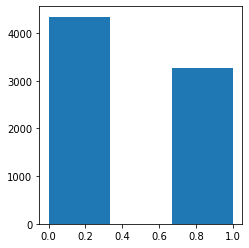

In [5]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["target"], bins=3
);

### Preprocess Data

In [6]:
data_text_columns = ["keyword", "location", 'text']
data[data_text_columns] = data[data_text_columns].fillna('NaN') # cast missing values to string "NaN"
data_test[data_text_columns] = data_test[data_text_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,id,keyword,location,text,target
4148,5896,harm,?semekeepschanging@soyeh?,PEOPLE KEEP NOT TAGGING SELF HARM AND IT'S FUC...,0
3250,4671,engulfed,NaN,Men escape car engulfed in flames in Parley's ...,1
2125,3053,deaths,NaN,#vaxshill 2 deaths from measles complications ...,1


In [7]:
data_test.sample(3)

,id,keyword,location,text
2484,8302,rubble,Worldwide,#360WiseNews : China's Stock Market Crash: Are...
1873,6307,hostage,Visit our dedicated website @,'IS Egypt affiliate threatens to kill Croatian...
2058,6906,mass%20murderer,NaN,@AParra210 So you are stereotyping the people....


### Import Models

In [8]:
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, BertForMaskedLM, BertModel, BertTokenizer

#unmasker = pipeline('fill-mask', model='bert-base-cased')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

bert_model = AutoModel.from_pretrained("bert-base-uncased")
classification_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
#model = BertForMaskedLM.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased')


#print(tokenizer("Hello I'm a [MASK] model.", return_tensors='pt'))
#unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerN

In [10]:
encode = tokenizer("Hello I'm a [MASK] model.", return_tensors='pt')
print("\n", encode)
#print(tokenizer.decode(encode['input_ids']))
classification_model(**encode)


 {'input_ids': tensor([[ 101, 7592, 1045, 1005, 1049, 1037,  103, 2944, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


SequenceClassifierOutput(loss=None, logits=tensor([[-0.0291,  0.1638]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [11]:
def apply_mask(example: tp.Dict[str, tp.Any]):
    
    # copy real input_ids:
    example['labels'] = example['input_ids'].detach().clone()
    
    # create random array of floats in equal dimension to input_ids
    rand = torch.rand(example['input_ids'].shape)

    # where the random array is less than 0.15, we set true
    mask_arr = rand < 0.15 *  (example['input_ids'] != 101) * (example['input_ids'] != 102) 
    
    # create selection from mask_arr
    selection = mask_arr.nonzero().tolist()
    
    for i in selection:
        example['input_ids'][i] = 103
    
    return example

### Get Train/Eval Dataset

In [12]:
def get_train_dataset(data, mask=True):
    text_dataset = []
    for index, row in data.iterrows():
        #print(index, row['keyword'], row['location'], row['text'])
        elem = tokenizer(row['text'])
        elem['input_ids'] = torch.as_tensor(elem['input_ids'])
        elem['token_type_ids'] = torch.tensor(elem['token_type_ids'])
        elem['attention_mask'] = torch.tensor(elem['attention_mask'])
        elem['tokens'] = row['text']
        elem['target'] = row['target']
        elem['id'] = row['id']
        if mask == True:
            elem = apply_mask(elem)
        text_dataset.append(elem)

    X_train, X_eval = train_test_split(text_dataset, test_size=0.33, random_state=42)

    print(len(X_train))
    print(len(X_eval))
    
    return X_train, X_eval 

X_train, X_eval = get_train_dataset(data, mask=False)
print(X_train[0])

5100
2513
{'input_ids': tensor([  101,  6302,  1024,  2695,  9331, 24755,  2135, 20746, 10258,  5714,
        10258,  3286,  1024,  4013, 27027,  2105,  1996, 17538,  1012,  8299,
         1024,  1013,  1013,  1056,  1012,  2522,  1013,  1038,  6292,  2549,
         2072, 22610,  3501, 19841,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'tokens': 'Photo: postapocalypticflimflam: Prodding around the rubble. http://t.co/Bgy4i47j70', 'target': 0, 'id': 8339}


### Get Test Dataset

In [13]:
def get_test_dataset(data_test, mask=True):
    test_dataset = []
    for index, row in data_test.iterrows():
        #print(index, row['keyword'], row['location'], row['text'])
        elem = tokenizer(row['text'])
        elem['input_ids'] = torch.as_tensor(elem['input_ids'])
        elem['token_type_ids'] = torch.tensor(elem['token_type_ids'])
        elem['attention_mask'] = torch.tensor(elem['attention_mask'])
        elem['tokens'] = row['text']
        elem['id'] = row['id']
        if mask == True:
            elem = apply_mask(elem)
        test_dataset.append(elem)
        
    return test_dataset


test_dataset = get_test_dataset(data_test, mask=False)
test_dataset[4]

{'input_ids': tensor([  101, 15393,  2061, 12672, 10626,  8563,  2654,  1999,  2859,  1998,
         6629,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'tokens': 'Typhoon Soudelor kills 28 in China and Taiwan', 'id': 11}

### Get Dataloader

In [15]:
from collections import defaultdict

class PadSequence:
    def __init__(self, padded_columns, device='cuda:1'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
            
        #print("done")       
        for key, val in padded_batch.items():
            #print(val)
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch


train_dataloader = torch.utils.data.DataLoader(X_train, 
                                               batch_size=32, 
                                               drop_last= True, 
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']
                                                                          ))

eval_dataloader = torch.utils.data.DataLoader(X_eval, 
                                              batch_size=32, 
                                              drop_last= True, 
                                              collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']
                                                                          ))


test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=32,  
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']
                                                                     ))
                                        

In [16]:
train_batch = next(iter(train_dataloader))
#train_batch = next(iter(eval_dataloader))
print(train_batch['target'])
#print(train_batch['labels'][0])

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


### Convergance Graph

In [17]:
import matplotlib.pyplot as plt
def convergence_graph(loss_vals):
    print("min loss value", loss_vals[-1])

    plt.plot(range(1, len(loss_vals) +1 ), loss_vals, color ='blue')
    plt.rcParams["figure.figsize"] = (10,6)
    plt.grid()
    plt.xlabel("Number of iterations")
    plt.ylabel("cost (J)")
    plt.title("Convergence of gradient descent")

### Binary Classifier

In [19]:
class BinClassifier(nn.Module):
    def __init__(self):
        super(BinClassifier, self).__init__()
        self.linear = nn.Linear(768, 2) 
        
        
    def forward(self, X):
        X = self.linear(X)
        return X

### Get CLS Sentence Embeddings

In [18]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        return model(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True).pooler_output

    
# emmbedding = get_sentence_embeddings(model, train_batch)
# emmbedding.shape

### Train Classifier of Classic Bert

In [19]:
def train_bin_class(classifier, model, dataloader, num_epochs=50, device='cuda:1'):
    classifier.to(device)
    classifier.train()
    
    model.to(device)
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    train_loss = []

    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        cnt = 0
        for batch in dataloader: 
            labels = torch.tensor(batch['class']).to(device)

            cls_logits = get_sentence_embeddings(model, batch)
            #print("\nlogits: ", cls_logits.shape)
            
            logits = classifier(cls_logits)
            #print("\nlogits: ", logits.shape)
            
            #print(labels.T.shape)
            loss = criterion(logits, torch.squeeze(labels.T))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_batch_loss.append(loss.item())
        
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        #print(avg)
        train_loss.append(avg)
        
    return train_loss

In [19]:
# classifier = BinClassifier()

# train_loss = train_bin_class(classifier, model, train_dataloader, num_epochs=100)

# torch.save(classifier.state_dict(), 'nlp-getting-started/weights/text_classifier.pth')

# convergence_graph(train_loss)

### Load Binary Classifier

In [20]:
classifier = BinClassifier()                                                                        # define model
classifier.load_state_dict(torch.load('nlp-getting-started/weights/text_classifier.pth'))           # load weights

<All keys matched successfully>

### Evaluate Model + Generate Submission of Classic Bert

In [21]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import statistics

def eval_model(classifier, model, dataloader, device='cuda:1', generate_csv=False):
    classifier.to(device)
    model.to(device)
    
    classifier.eval()
    model.eval()
    
    df = pd.DataFrame(columns=['id', 'target'])

    scores = {"accuracy": [], "f1_score": [], "recall": [], "precision": []}
    for batch in tqdm(dataloader):
        with torch.no_grad():
            cls_logits = get_sentence_embeddings(model, batch)
            logits = classifier(cls_logits)                           # get logits
            prob = F.softmax(logits, -1)                              # get log-SoftMax
            prob = torch.argmax(prob, -1)                             # get argMax
            prob = prob.detach().cpu().tolist()                       # to cpu
        
        if generate_csv == True:
            ids = batch['id']
            for i in range(len(prob)):
                #print(len(prob))
                #print(len(batch['id']))
                df = df.append({'id': batch['id'][i], 'target':  prob[0]}, ignore_index=True)
            df.to_csv("submission.csv", index=False);
        else:
            labels = batch['labels']
            scores["accuracy"].append(accuracy_score(labels, prob))
            scores["f1_score"].append(f1_score(labels, prob, average='macro'))
            scores["recall"].append(recall_score(labels, prob))
            scores["precision"].append(precision_score(labels, prob)) 
            
    if generate_csv == False:
        return {
            "accuracy":  statistics.mean(scores['accuracy']), 
            "f1_score": statistics.mean(scores['f1_score']), 
            "recall": statistics.mean(scores['recall']),
            "precision": statistics.mean(scores['precision']),
            }
    return 0
            

### Get BaseLine

In [22]:
# # eval train 
# scores = eval_model(classifier, model, train_dataloader, device='cuda:1')
# print(scores)

# # eval test
# scores = eval_model(classifier, model, eval_dataloader, device='cuda:1')
# print(scores)

# # test test
# scores = eval_model(classifier, model, test_dataloader, device='cuda:1', generate_csv=True)
# print(scores)

### FineTune BertForSequenceClassification

In [46]:
def finetune_classification(model, dataloader, num_epochs=50, device='cuda:1'):
    model.to(device)
    model.train()
    
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_loss = []

    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in dataloader: 
            targets = torch.tensor(batch['target']).to(device)
            outputs = model(input_ids=batch['input_ids'], 
                            attention_mask=batch['attention_mask'],
                            labels=targets)
            
            loss = outputs.loss
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_batch_loss.append(loss.item())
        
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        #print(avg)
        train_loss.append(avg)
        
    return train_loss

100%|██████████████████████████████████████████████████████████| 100/100 [31:36<00:00, 18.97s/it]


min loss value 0.6839243102373567


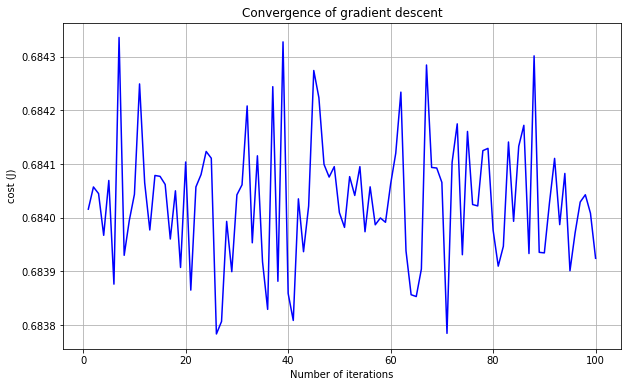

In [47]:
train_dataloader = torch.utils.data.DataLoader(X_train, 
                                               batch_size=32, 
                                               drop_last= True, 
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device='cuda:1'
                                                                          ))


train_loss = finetune_classification(classification_model, train_dataloader, num_epochs=100, device='cuda:1')

torch.save(classification_model.state_dict(), 'nlp-getting-started/weights/sequence_classification.pth')

convergence_graph(train_loss)

### Load Model

In [42]:
classification_model = classification_model.to('cuda:1')                                                                                         # define model
classification_model.load_state_dict(torch.load('nlp-getting-started/weights/sequence_classification.pth'))           # load weights

<All keys matched successfully>

### Classification Eval + Submission CSV

In [21]:
train_batch = next(iter(train_dataloader), 3)
print(train_batch['input_ids'])
print(train_batch['target'])

tensor([[  101,  6302,  1024,  ...,     0,     0,     0],
        [  101,  1996,  2203,  ...,     0,     0,     0],
        [  101,  2158, 10188,  ...,     0,     0,     0],
        ...,
        [  101,  2004,  1037,  ...,     0,     0,     0],
        [  101,  1031,  1001,  ...,     0,     0,     0],
        [  101,  1030, 29318,  ...,     0,     0,     0]], device='cuda:1')
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


In [22]:
classification_model.device

device(type='cuda', index=1)

In [44]:
classification_model(train_batch['input_ids'], train_batch['attention_mask']).logits

tensor([[ 0.1311, -0.1242],
        [ 0.1688, -0.1091],
        [ 0.1249, -0.1329],
        [ 0.1715, -0.0840],
        [ 0.1319, -0.1190],
        [ 0.1789, -0.1146],
        [ 0.1290, -0.1142],
        [ 0.1532, -0.0904],
        [ 0.1342, -0.1150],
        [ 0.1314, -0.1198],
        [ 0.1451, -0.1124],
        [ 0.1271, -0.1369],
        [ 0.1878, -0.1086],
        [ 0.1575, -0.1136],
        [ 0.1075, -0.1317],
        [ 0.1202, -0.1286],
        [ 0.1524, -0.1134],
        [ 0.1854, -0.0947],
        [ 0.2005, -0.1021],
        [ 0.1598, -0.0644],
        [ 0.1211, -0.1273],
        [ 0.1283, -0.1178],
        [ 0.1351, -0.1168],
        [ 0.1566, -0.1165],
        [ 0.1639, -0.1045],
        [ 0.1546, -0.1135],
        [ 0.1650, -0.0930],
        [ 0.1394, -0.1206],
        [ 0.1430, -0.1141],
        [ 0.1548, -0.1082],
        [ 0.1836, -0.1012],
        [ 0.1288, -0.1128]], device='cuda:1', grad_fn=<AddmmBackward>)

In [33]:
inputs = tokenizer("hello great and good", return_tensors="pt")
print(inputs.to('cuda:1'))
classification_model(**inputs)

{'input_ids': tensor([[ 101, 7592, 2307, 1998, 2204,  102]], device='cuda:1'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]], device='cuda:1'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:1')}


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1280, -0.1006]], device='cuda:1', grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

## PreTraining


In [27]:
pretrained = deepcopy(model)

In [25]:
def pre_train_model(model, loader, num_epochs=10, device='cuda:1'):
    model.to(device)
    model.train() 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in tqdm(loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            masked_ids = batch['masked_ids']
            
            outputs = model(masked_ids, input_ids,attention_mask=attention_mask)
            loss = outputs.loss
            print(loss)
            loss.backward()
            optimizer.step()
#             loss = criterion(logits, batch['true_labels'])

            

In [26]:
pre_train_model(pretrained, train_dataloader, num_epochs=10, device='cuda:1')

  0%|                                                                                                                                            | 0/10 [00:00<?, ?it/s]


TypeError: forward() got multiple values for argument 'attention_mask'

In [ ]:
X_train[0]

In [31]:
bert_model.forward?

In [33]:
batch = next(iter(train_dataloader))
outputs = pretrained.forward(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], label=)
outputs

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [59]:
from transformers import BertTokenizer, BertForPreTraining
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

prediction_logits = outputs.prediction_logits
seq_relationship_logits = outputs.seq_relationship_logits

print(outputs)

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForPreTrainingOutput(loss=None, prediction_logits=tensor([[[ -7.8962,  -7.8105,  -7.7903,  ...,  -7.0694,  -7.1693,  -4.3590],
         [ -8.4461,  -8.4401,  -8.5044,  ...,  -8.0625,  -7.9909,  -5.7160],
         [-15.2953, -15.4727, -15.5865,  ..., -12.9857, -11.7038, -11.4293],
         ...,
         [-14.0628, -14.2535, -14.3645,  ..., -12.7151, -11.1621, -10.2317],
         [-10.6576, -10.7892, -11.0402,  ..., -10.3233, -10.1578,  -3.7721],
         [-11.3383, -11.4590, -11.1767,  ...,  -9.2152,  -9.5209,  -9.5571]]],
       grad_fn=<AddBackward0>), seq_relationship_logits=tensor([[ 3.3474, -2.0613]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)


In [42]:
model.forward?

In [47]:
model.to('cuda:1')
batch = next(iter(train_dataloader))
model.train()
outputs = model.forward(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])

In [52]:
outputs.keys()

odict_keys(['prediction_logits', 'seq_relationship_logits'])

In [53]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_lm = BertForMaskedLM.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
model_lm.to('cuda:1')
batch = next(iter(train_dataloader))
model_lm.train()
lm_outputs = model_lm.forward(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])

In [55]:
lm_outputs.keys()

odict_keys(['loss', 'logits'])

In [56]:
lm_outputs.loss

tensor(10.1242, device='cuda:1', grad_fn=<NllLossBackward>)

In [57]:
lm_outputs.logits.shape

torch.Size([32, 57, 30522])

In [60]:
model_lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr